In [67]:
import numpy as np
from matplotlib import pyplot as plt
import math
from dataclasses import dataclass
from functools import cache
from typing import Optional, List
from sortedcontainers import SortedDict
import scipy.constants as sci_const

In [68]:
class Particle:
    """
    A particle in a one-dimensional electrostatic cold stream plasma.

    Attributes:
    -----------
    id : int
        Label to preserve order of particles
    alpha : float
        The Lagrangian coordinate of the particle, ranging from 1:N
    x : float
        The position of the particle in the domain [0,1).
    v : float
        The velocity of the particle.
    """
    id: int
    alpha: float
    x: float
    v: float
    a: float
    active: bool
    pos_hist: list
    vel_hist: list
    periods_traversed : int = 0
    period_hist: list 

    def __init__(self, id_in: int, N: int, epsilon: float, types: bool = False, neighbors: tuple = None):
        """
        Initialize the particle with a given position and set all other attributes to zero.
        
        Parameters:
        -----------
        id_in : int
            The ID of the particle.
        N_in : int
            The total number of particles.
        epsilon : float
            magnitude of perturbation to initial setup
        types : bool 
            flag determining if particles should be generated with passive/active distiction or
            not, defaults to False. 
        neighbors : tuple of Particles
            optional argument that when present creates a particle "between" the neighbors
        """
        self.id = id_in

        if neighbors == None: # Brand new particle
            if types:
                self.active = True if self.id % 2 == 0 else False
                self.alpha = (self.id - 1) / (N) # Create particles at midpoints and edges of intervals
            else:
                self.active = True
                self.alpha = (self.id - 0.5) / N # Create particles only at midpoints
            self.x = self.alpha + epsilon*np.sin(2* np.pi * self.alpha)
            self.v = 0.0
            self.a = 0.0
            self.pos_hist = [self.x]
            self.vel_hist = [self.v]
            self.acc_hist = [0]
            self.period_hist = [0]
        else:
            p1, p2 = neighbors
            self.active = True # Inserted particles are always active
            self.alpha = 0.5 * (p1.alpha + p2.alpha) # Lagrangian coordinate is midpoint
            self.x = 0 # TODO add quadratic interpolation for x and v
            self.v = 0
            self.a = 0
            # Initialize all pos and vel arrays to zeros up to present
            self.pos_hist = [0] * (len(p1.pos_hist) - 1)
            self.pos_hist.append(self.x)
            self.vel_hist = [0] * (len(p1.vel_hist) - 1)
            self.pos_hist.append(self.v)
            self.acc_hist = [0] * (len(p1.acc_hist))
            self.period_hist = [0] * (len(p1.period_hist))
        

    def __lt__(self, other):
        """
        Compare two particles with respect to their Lagrangian Coordinates

        Parameters:
        -----------
        other : Particle
            The other particle that the current one will be compared to

        """
        return self.alpha < other.alpha
        


    def update_position(self, new_x):
        """
        Update the position of the particle based on its current velocity and the
        elapsed time using Euler's Method.
        
        Args:
            dt (float): The elapsed time in seconds.
        
        Returns:
            None
        """
        self.x = new_x
        if self.x > 1: self.periods_traversed += 1
        if self.x < 0: self.periods_traversed -= 1
        self.x = self.x % 1
        self.pos_hist.append(self.x)
        self.period_hist.append(self.periods_traversed)


    def update_velocity(self, new_v):
        """
        Update the velocity of the particle based on the given acceleration and
        the elapsed time using Euler's Method.
        
        Args:
            acceleration (float): The acceleration of the particle.
            dt (float): The elapsed time in seconds.
        
        Returns:
            None
        """
        if self.id != 1 or self.active:
            self.v = new_v
        self.vel_hist.append(self.v)

    def update_acceleration(self, acceleration):
        """
        Update the acceleration of the particle based on the given acceleration
        function.
        
        Args:
            acceleration (float): The acceleration of the particle.
        
        Returns:
            None
        """
        self.a = acceleration(self)
        self.acc_hist.append(self.a)



In [69]:
class Plasma_Evolver:


    N: int
    dt: float
    epsilon: float
    delta: float
    ion_density: float = 1
    plasma : SortedDict
    t: float = 0
    kernel: callable
    green: callable
    
    def __init__(self, N_in: int, dt_in: float,
                  epsilon_in: float = 0.05, delta_in: float = 0.002, insertion: bool = False, rk: bool = False):
        """
        Initializes Plasma_Evolver class, setting parameters and initializing the plasma in
        a Sorted Dict

        Args:
        - N_in (int): The number of particles to generate.
        - dt_in (float): Simulation timestep
        - epsilon (float): Magnitude of the perturbation. Defaults to 0.05.

        """
        self.N = N_in
        self.dt = dt_in
        self.epsilon = epsilon_in
        self.delta = delta_in
        self.plasma = SortedDict()
        self.weights = SortedDict()
        self.insertion = insertion
        self.rk = rk
        self.Ep_hist = []
        self.Ek_hist = []
        self.epsilon = epsilon_in

        for i in range(1, self.N+1):
            p = Particle(i, self.N, epsilon=self.epsilon, types = insertion)
            self.plasma[p.alpha] = p
        
        for p in self.plasma.values():
            self.weights[p.alpha] = self.get_w(p)

        self.Ep_hist.append(self.calc_Ep())
        self.Ek_hist.append(self.calc_Ek())

    def get_prev(self, p: Particle, same_type: bool = True) -> tuple:
        """Returns the previous particle in the self.plasma array. If same_type 
        is true, then it returns the first previous particle of the same type (active/pasive). 
        Assumes N is even 

        Args:
            p (Particle): reference particle
            same_type (bool, optional): same_type flag. Defaults to True.

        Returns:
            Particle: previous particle matching type if same_type is True
            wrap_around: flag to determine if next particle is on the other side of interval
        """

        if self.insertion: assert(self.N % 2 == 0)

        index = self.plasma.bisect_left(p.alpha)

        if same_type:
            prev_index = index - 2
        else:
            prev_index = index -1

        wrap_around = True if prev_index < 0 else False

        return list(self.plasma.values())[prev_index], wrap_around
    
    def get_next(self, p: Particle, same_type: bool = True) -> tuple:
        """Returns the next particle in the self.plasma array. If same_type 
        is true, then it returns the first next particle of the same type (active/pasive). 
        Assumes N is even.

        Args:
            p (Particle): reference particle
            same_type (bool, optional): same_type flag. Defaults to True.

        Returns:
            Particle: next particle matching type if same_type is True
            wrap_around: flag to determine if next particle is on the other side of interval
        """

        if self.insertion: assert(self.N % 2 == 0)

        index = self.plasma.bisect_left(p.alpha)

        if same_type:
            prev_index = index + 2
        else:
            prev_index = index + 1

        wrap_around = True if (prev_index >= len(self.plasma.values())) else False
            
        prev_index = prev_index % len(self.plasma.values())

        return list(self.plasma.values())[prev_index], wrap_around

    def calc_next_dist(self, p: Particle) -> float:

        p_next, wrap = self.get_next(p)
        
        if not wrap:
            p_coords = np.array([p.x, p.v])
            p_next_coords = np.array([p_next.x, p_next.v])

            dist = np.linalg.norm(p_next_coords - p_coords)
        else:
            p_coords = np.array([p.x, p.v])
            p_next_coords = np.array([p_next.x + 1, p_next.v])

            dist = np.linalg.norm(p_next_coords - p_coords)

        return dist
       
    def calc_dist2chord(self, p1: Particle):

        p2, wrap2 = self.get_next(p1, same_type=False) # next particle
        p3, wrap3 = self.get_next(p1) # next particle of same type

        x1, y1 = p1.x, p1.v
        x2, y2 = p2.x, p2.v
        x3, y3 = p3.x, p3.v

        # Fix wrap around to ensure distances are right
        if wrap2:
            x2 += 1
        if wrap3:
            x3 += 1

        # Calculate the slope of the line connecting p1 and p3
        slope = (y3 - y1) / (x3 - x1)

        # Calculate the y-intercept of the line connecting p1 and p3
        intercept = y1 - slope * x1

        # Calculate the perpendicular distance from p2 to the line
        distance = abs(slope * x2 - y2 + intercept) / math.sqrt(slope ** 2 + 1)

        return distance
 
    def get_w(self, p: Particle) -> float:

        p_prev, wrap = self.get_prev(p, same_type=self.insertion)

        if not wrap:
            return p.alpha - p_prev.alpha
        else:
            return 1 - (p_prev.alpha - p.alpha) 
        
    def get_pos_array(self):

        return np.array([p.x for p in self.plasma.values()],dtype=float)
    
    def get_vel_array(self):

        return np.array([p.v for p in self.plasma.values()],dtype=float)
    
    def update_particles(self, new_x: np.array, new_v: np.array) -> None:

        for i, p in enumerate(self.plasma.values()):
            p.update_position(new_x[i])
            p.update_velocity(new_v[i])

    def calc_Ek(self):

        vel = self.get_vel_array()
        Ek = 0.5 * np.sum(np.power(vel, 2))
        return Ek


    def calc_Ep(self):

        """Calculates the potential for all particles in 1D
        """

        # Get positions
        pos = self.get_pos_array()
        w = weights = np.array(self.weights.values(), dtype=float)
        # Calculate absoolute value of differences between all positions
        diff_matrix = 0.5 * np.abs(pos[:, np.newaxis] - pos[np.newaxis, :])
        square_matrix = np.transpose(np.tile(pos * pos, (pos.shape[0], 1)))
        product_matrix = pos[:, np.newaxis] * pos[np.newaxis, :]
        potential_matrix = (diff_matrix - square_matrix + product_matrix) * w
        particle_potential = np.sum(potential_matrix, axis=1)
        total_potential = np.sum(particle_potential)
        return total_potential


    def kd(self, p1: float, p2: float) -> float:

        p2 = p2 - p1
        p1 = 0 
    
        p1 = (p1 - 0.5) % 1 + 0.5
        p2 = (p2 - 0.5) % 1 + 0.5

        diff = p1 - p2
        c = np.sqrt(1 + 4*self.delta**2)

        if self.delta == 0:
            return c*0.5 * np.sign(diff) - diff

        return np.where(diff == 0, 0, 0.5 * c * diff / np.sqrt(diff**2 + self.delta**2 )- diff)


    def gd(self, p1: float, p2: float) -> float:
        return -0.5 * np.sqrt((p1 - p2)**2 + self.delta**2)
    
    def calc_acceleration_reg(self, x_arr: np.array, v_arr: np.array) -> float:

        """
        Calculates the acceleration on a given particle due to rest of the stream
        with regularization

        Returns:
            float: acceleration
        """

        weights = np.array(self.weights.values(), dtype=float)


        # Broadcast positions to get a 2D array of values of Green's Function kd
        # over all particles. i,j entry corresponds to the values of kd(xi, xj) 
        # for i,j = 1:N
        k_map = np.array([self.kd(x_arr[:, np.newaxis], x_arr)])[0]
        # Multiply each row by the corresponding weights
        weighted_k_map = k_map * weights
        # Add up each row to get electric field force felt by each particle
        k_contribution = np.sum(weighted_k_map, axis=1)

        """ print("K map")
        print(k_map)
        print("\nweighted k map")
        print(weighted_k_map)
        print("\n Acceleration") """



        first = - k_contribution

        acc = first
 
        return acc
    
    def euler_update(self, fx: callable, fv: callable , x0: np.array, v0: np.array) -> tuple:

        dx = fx(x0, v0)
        dv = fv(x0, v0)

        new_x = x0 + dx * self.dt
        new_v = v0 + dv * self.dt

        return new_x, new_v
    
    def rk4_update(self, fx: callable, fv: callable , x0: np.array, v0: np.array) -> tuple:

        k1x = fx(x0, v0)
        k1v = fv(x0, v0)
        k2x = fx(x0 + 0.5 * self.dt * k1x, v0 + 0.5 * self.dt * k1v)
        k2v = fv(x0 + 0.5 * self.dt * k1x, v0 + 0.5 * self.dt * k1v)
        k3x = fx(x0 + 0.5 * self.dt * k2x, v0 + 0.5 * self.dt * k2v)
        k3v = fv(x0 + 0.5 * self.dt * k2x, v0 + 0.5 * self.dt * k2v)
        k4x = fx(x0 + self.dt * k3x, v0 + self.dt * k3v)
        k4v = fv(x0 + self.dt * k3x, v0 + self.dt * k3v)

        new_x = x0 + (1/6) * self.dt * (k1x + 2 * k2x + 2 * k3x + k4x)
        new_v = v0 + (1/6) * self.dt * (k1v + 2 * k2v + 2 * k3v + k4v)

        return new_x, new_v
    
    def evolve_plasma(self, time: float):
        """
        Evolves the plasma for the given amount of time

        Args:
            time (float): Time to evolve plasma over
        """

        self.t += time

        for _ in range(int(time / self.dt)):
            x_arr = self.get_pos_array()
            v_arr = self.get_vel_array()

            if self.rk: new_x, new_v = self.rk4_update(lambda x,v: v, self.calc_acceleration_reg, x_arr, v_arr)
            else: new_x, new_v = self.euler_update(lambda x,v: v, self.calc_acceleration_reg, x_arr, v_arr)

            self.update_particles(new_x, new_v)
            self.Ep_hist.append(self.calc_Ep())
            self.Ek_hist.append(self.calc_Ek())
                
    def plot_particles(self,times: tuple = (-1,), periods: int = 1, zoom: bool = False):
        """
        Plots particles stored in a sorted dictionary in phase space as points where
        the x-coordinate is position and the y-coordinate is velocity, and lines that 
        connect neighboring particles on the sorted dictionary.
        
        Args:
        - zoom (bool): boolean to zoom in into the center.
        
        Returns:
        - None
        """

        cmap = plt.get_cmap('tab10')

        colors = [cmap(i) for i in range(periods)]

        size = (5*periods,2*len(times))

        if zoom:
            times = (times[-1],)
            periods = 1
            size = (8,6)

        fig, axs = plt.subplots(len(times), 1, figsize=size, dpi=120)
        

        # Convert axs to an iterable if it contains a single subplot
        axs = np.atleast_1d(axs)

        fig.suptitle(r'Particle Phase Space ($N = {}$, $\delta = {}$)'.format(self.N, self.delta))
        #fig.text(0.5, 0.01, 'Position', ha='center')
        #fig.text(0.04, 0.5, 'Velocity', va='center', rotation='vertical')
        


        for num, t in enumerate(times):

            if t == -1 or t > self.t:
                t = self.t
            
            index = int(t / self.dt)
            
            # Extract positions and velocities of particles
            positions = np.array([(p.pos_hist[index] + p.period_hist[index]) for p in self.plasma.values()])
            
            velocities = np.array([p.vel_hist[index] for p in self.plasma.values()])
            

            # Plot particles as points in phase space
            axs[num].set_xlim((0,periods))
            axs[num].set_ylim((-0.5,0.5))

            # Add lines connecting neighboring particles on the sorted dictionary
            for j in range(-1, periods + 1):
                axs[num].plot(positions + j, velocities, marker='.', markersize=4, alpha=0.8, linewidth=0.7)
                axs[num].set_title("t = " + str(t))
                if zoom: axs[num].hlines(y=0, xmin=0, xmax=periods, linewidth = 1, color = 'b', linestyle = '--')
                """ for i, (k, p) in enumerate(self.plasma.items()):
                    if i == 0:
                        if j != 0:
                            prev_p = list(self.plasma.values())[-1]
                            print([prev_p.pos_hist[index] + j - 1, p.pos_hist[index] + j ])
                            #axs[num].plot([prev_p.pos_hist[index] + j - 1, p.pos_hist[index] + j ], 
                            #        [prev_p.vel_hist[index], p.vel_hist[index]], color=colors[j], alpha=0.3)
                        continue
                    prev_p = list(self.plasma.values())[i-1]
                    axs[num].plot([prev_p.pos_hist[index] + j + prev_p.period_hist[index], 
                                   p.pos_hist[index] + j + p.period_hist[index]], 
                                [prev_p.vel_hist[index], p.vel_hist[index]], color=colors[j], alpha=0.3) """

            if zoom:
                axs[num].set_xlim((0.45, 0.55))
                axs[num].set_ylim((-0.1, 0.1))
                
        fig.tight_layout()
        plt.show()


            
        

In [70]:
def k(p1: float, p2: float, delta: float) -> float:
    diff = p1 - p2
    if (diff > 0):
        return 0.5 
    elif diff < 0:
        return -0.5
    return 0

def gd(p1: float, p2: float, delta: float) -> float:
    return -0.5 * math.sqrt((p1 - p2)**2 + delta**2)

def kd(p1: float, p2: float, delta: float) -> float:
    diff = p1 - p2
    mask = diff == 0
    if diff != 0: return 0.5 * diff / math.sqrt(diff**2 + delta**2)
    return 0


In [100]:
N = 256
dt = 0.01
driver = Plasma_Evolver(N, dt, epsilon_in=0.05, delta_in=0, insertion=False, rk = False)


tmax = 5


driver.evolve_plasma(tmax)

#driver.plot_particles(periods=1)
#driver.plot_particles(zoom=True)




#a = [p.vel_hist[1] for p in driver.plasma.values()]

#driver.plot_particles([i for i in range(0,tmax + 1,1)], periods=2)



1.9521264084674068


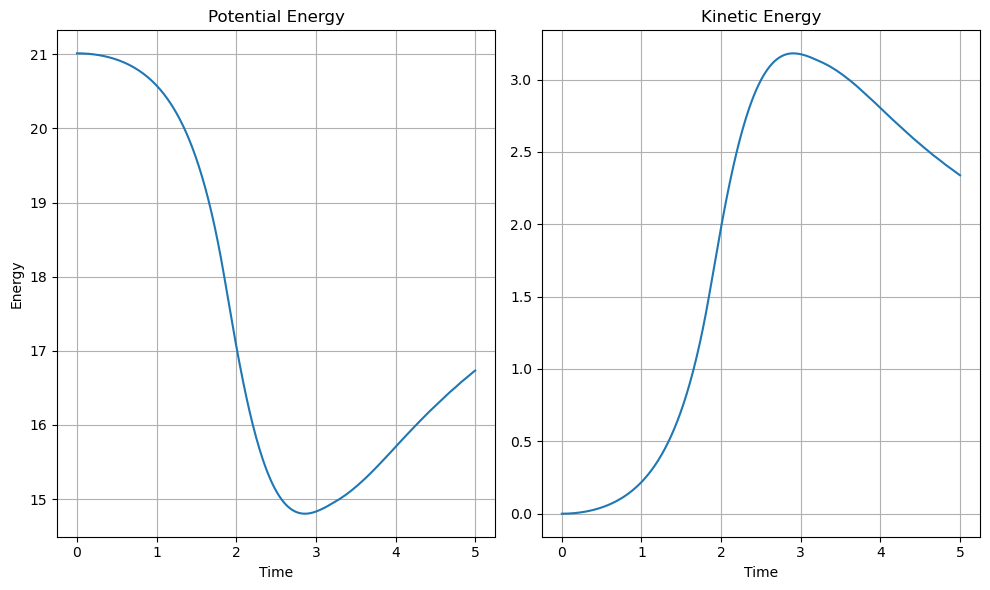

In [101]:
t = np.arange(0, tmax + 0.01, 0.01)


E0 = (driver.Ek_hist[0] + driver.Ep_hist[0])
E_net = np.array(driver.Ek_hist) + np.array(driver.Ep_hist)

E_error = np.abs(E_net - E0)

fig, axs = plt.subplots(1,2, figsize=(10,6))

axs[0].plot(t, np.array(np.array(driver.Ep_hist)))
axs[0].set_xlabel("Time")
axs[0].set_title("Potential Energy")
axs[0].set_ylabel("Energy")
axs[0].grid()
axs[1].plot(t, driver.Ek_hist)
axs[1].set_xlabel("Time")
axs[1].set_title("Kinetic Energy")
axs[1].grid()
#axs[2].plot(t, E_net)

fig.tight_layout()

print((np.max(driver.Ep_hist) - np.min(driver.Ep_hist)) / (np.max(driver.Ek_hist) - np.min(driver.Ek_hist)))

C:\Users\yayin\AppData\Local\Temp\ipykernel_23660\2639500153.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = np.abs(np.array(driver.Ep_hist) - driver.Ep_hist[0]) / np.array(driver.Ek_hist)


Text(0.5, 1.0, 'Ratio of Total Change in Potential Energy to \nTotal Change in Kinetic Energy for N = 256')

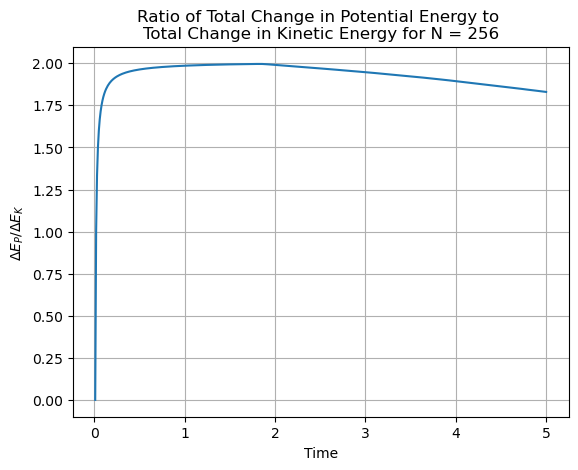

In [102]:
ratio = np.abs(np.array(driver.Ep_hist) - driver.Ep_hist[0]) / np.array(driver.Ek_hist)

plt.plot(t, ratio)
plt.grid()
plt.xlabel("Time")
plt.ylabel(r"$\Delta E_P / \Delta E_K$")
plt.title("Ratio of Total Change in Potential Energy to \n" "Total Change in Kinetic Energy for N = {}".format(N))

In [95]:
driver = Plasma_Evolver(50, 0.01, kd, gd, delta_in=0.002)


p1 = driver.plasma[0]

print("Time = {}, distance from particle to next = {}.".format(driver.t, driver.calc_next_dist(p1)))

for i in range (5):     
    driver.evolve_plasma(1) 
    print("Time = {}, distance from particle to next = {}, distance to chord = {}.".format(driver.t, driver.calc_next_dist(p1), driver.calc_dist2chord(p1)))

driver.plot_particles([i for i in range(0,5 + 1,1)], periods=2)




TypeError: Plasma_Evolver.__init__() got multiple values for argument 'delta_in'

In [ ]:

def k(xi, xj):
    return xi - xj

x_arr = np.array([1, 2, 3, 4, 5])  # Example array of positions

diff_arr = k(1, x_arr) - k(0, x_arr)

print(diff_arr)

[1 1 1 1 1]
